
In <a href='https://medium.com/intellectual-explorers-club/memetic-tribes-and-culture-war-2-0-14705c43f6bb' target='_blank'>Memetic Tribes and Culture War 2.0</a>, Peter Limberg and Conor Barnes reference a Google Spreadsheet where they are compiling their data.

<figure name="7247" id="7247" class="graf graf--figure graf--layoutOutsetCenter graf-after--p" data-scroll="native">
    <img src="https://cdn-images-1.medium.com/max/1000/1*k3zWQFbKT51T96AAMdfKdA.png">
    <figcaption class="imageCaption">
        Click <a href="https://docs.google.com/spreadsheets/d/11Ov1Y1xM-LCeYSSBYZ7yPXJah2ldgFX4oIlDtdd7-Qw/edit?usp=sharing" target="_blank">here</a> to view the full chart.
    </figcaption>
</figure>

One of the columns contains lists of records from another column. I am going to convert this into a directed graph using <code>pandas</code> and <code>networkx</code>.

The easiest way to get data out of html tables on the web is to use <code>pandas</code> <code>read_html</code> function, but you have to pick through the tables in the list to see which one contains the data you want.

In [108]:

%pprint

Pretty printing has been turned OFF


In [1]:

import pandas as pd

tables_url = r'https://docs.google.com/spreadsheets/d/11Ov1Y1xM-LCeYSSBYZ7yPXJah2ldgFX4oIlDtdd7-Qw'
tribes_df_list = pd.read_html(tables_url)
print(len(tribes_df_list))

2



I had to perform a lot of <a href='https://secure.i.telegraph.co.uk/multimedia/archive/02152/panda-upside-down_2152868i.jpg' target='_blank'>panda gymnastics</a> in order to clean off the husk of the Google table and get the data into a compact space.

In [2]:

tribes_df = tribes_df_list[0].dropna(axis=0, how='all').dropna(axis=1, how='all').iloc[:, 1:]
tribes_df.columns = tribes_df.iloc[0]
tribes_df = tribes_df.iloc[1:].T
tribes_df.columns = tribes_df.iloc[0]
tribes_df = tribes_df.iloc[1:].T
tribes_df.sample(3).T.sample(6).T

,MASTER STATUS,CHIEFTAINS,FOREBEARS,SACRED VALUES,EXISTENTIAL THREATS,COMBATANTS
MEMETIC TRIBE,,,,,,
DSA (Democratic Socialists of America),Democratic Socialist,"Alexandria Oscasio-Cortez, Julia Salazar, Bern...","Michael Harrington, Jeremy Corbyn, Bernie Bros","Economic Justice, Progress",Neoliberalism,"Establishment Left, Establishment Right, Trump..."
Occupy,Protester,"Kalle Lasn, Naomi Klein, David Graeber","Adbusters, Arab Spring",Economic Justice,Police crackdown,"Establishment Left, Establishment Right"
Gender-Critical Feminists,Liberated (biological) woman,"Meghan Murphy, Germaine Greer, Sheilay Jeffreys",Janice Raymond,Gender Equality,Continued Patriarchy,"SJA, MRA"



It's an easy matter to add the tribes into a directional graph.

In [3]:

import networkx as nx

tribes_digraph = nx.DiGraph()
tribes_digraph.add_nodes_from(tribes_df.T.to_dict())


Next is figuring out, from the combatant lists, where the edges are.

In [4]:

from difflib import SequenceMatcher

def similar(a, b):
    return SequenceMatcher(None, a, b).ratio()

tribe_list = tribes_df.index.tolist()
for row_index, row_value in tribes_df['COMBATANTS'].iteritems():
    combatant_list = row_value.split(', ')
    for combatant in combatant_list:
        if combatant != 'None':
            
            # The combatants are in slightly differing spellings,
            # so I need to just guess which one I mean
            this_tribe = sorted(tribe_list,
                                key=lambda tribe: similar(combatant, tribe.split(' (')[0]))[-1]
            
            tribes_digraph.add_edge(row_index, this_tribe)


I have to use Gephi to get every node away from the other edges because `networkx` doesn't do that well enough.

In [5]:

import os

# Export the graph into Gephi
SAVES_FOLDER = '../saves/'
gexf_dir = os.path.join(SAVES_FOLDER, 'gexf')
os.makedirs(name=gexf_dir, exist_ok=True)
file_name = 'tribes_digraph.gexf'
file_path = os.path.join(gexf_dir, file_name)
nx.write_gexf(tribes_digraph, file_path)
message_str = '''
1) Launch Gephi
2) In the File menu, open {}
3) Select and run the Fruchterman Reingold layout
4) Select and run the Label Adjust layout
5) In the File/Export submenu, select Graph file... and overwrite the old {}
6) Repeat 2) through 5) as necessary
'''
print(message_str.format(os.path.abspath(file_path), file_name))


1) Launch Gephi
2) In the File menu, open D:\Documents\Repositories\notebooks\Miscellaneous\saves\gexf\tribes_digraph.gexf
3) Select and run the Fruchterman Reingold layout
4) Select and run the Label Adjust layout
5) In the File/Export submenu, select Graph file... and overwrite the old tribes_digraph.gexf
6) Repeat 2) through 5) as necessary




I have decided to color the mutual combatants' edge red. For this I need a list of edges that have arrows pointing both ways.

In [6]:

full_edge_list = list(tribes_digraph.edges())
double_edge_list = []
while len(full_edge_list) > 0:
    edge_tuple = full_edge_list.pop()
    doubled_tuple = (edge_tuple[1], edge_tuple[0])
    if doubled_tuple in full_edge_list:
        double_edge_list.append(edge_tuple)
        double_edge_list.append(doubled_tuple)

In [7]:

single_edge_list = []
full_edge_list = list(tribes_digraph.edges())
for edge_tuple in full_edge_list:
    if edge_tuple not in double_edge_list:
        single_edge_list.append(edge_tuple)

In [9]:

import sys

!{sys.executable} -m pip install xmltodict

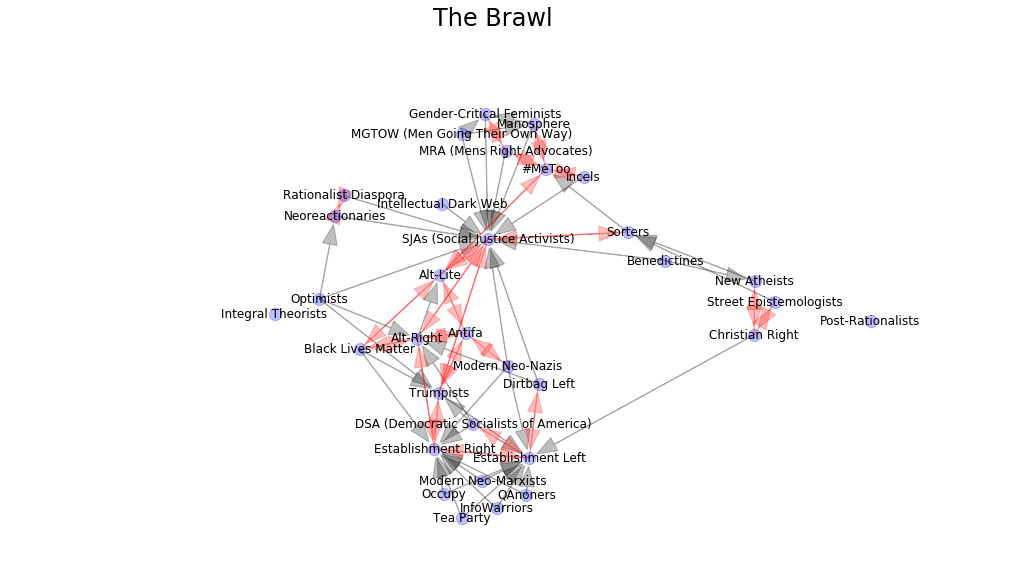

In [15]:

import xmltodict
import numpy as np
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
%matplotlib inline

# Import from Gephi
with open(file_path, 'r') as fid:
    tribal_xml = fid.read()
tribal_tree = xmltodict.parse(tribal_xml)

# Get the position dictionary for the GEXF saved from Gephi
node_dict_list = tribal_tree['gexf']['graph']['nodes']['node']
tribal_layout_dict = {node_dict['@id']: np.array([float(node_dict['viz:position']['@x']),
                                                  float(node_dict['viz:position']['@y'])])
                      for node_dict in node_dict_list}

# Draw the graph using the gephi layout
tribal_fig = plt.figure(figsize=(18, 9))
ax = tribal_fig.add_subplot(111)
plt.axis('off')
plt.xticks([], [])
plt.yticks([], [])
tribal_fig.suptitle('The Brawl', fontsize=24)

# Make fat arrows
arrowstyle = mpatches.ArrowStyle.Simple(head_length=2., head_width=1.5, tail_width=0.05)

# Make the nodes blue so you can make the double edges red
node_collection = nx.draw_networkx_nodes(G=tribes_digraph, pos=tribal_layout_dict, alpha=0.25,
                                         node_color='b', node_size=150)

# Get the double-edged edge list in red
edge_collection = nx.draw_networkx_edges(G=tribes_digraph, pos=tribal_layout_dict, alpha=0.25,
                                         arrowstyle=arrowstyle, edgelist=single_edge_list)
edge_collection = nx.draw_networkx_edges(G=tribes_digraph, pos=tribal_layout_dict, alpha=0.25,
                                         arrowstyle=arrowstyle, edgelist=double_edge_list,
                                         edge_color='r')

labels_collection = nx.draw_networkx_labels(G=tribes_digraph, pos=tribal_layout_dict, font_size=12)
axes_subplot = tribal_fig.get_axes()[0]
xlim_tuple = axes_subplot.set_xlim(left=-1500, right=1500)

In [23]:

tribes_digraph.adj

AdjacencyView({'SJAs (Social Justice Activists)': {'Alt-Lite': {}, 'Alt-Right': {}, 'Sorters': {}, 'Trumpists': {}}, 'Black Lives Matter': {'Alt-Lite': {}, 'Alt-Right': {}, 'Trumpists': {}, 'Establishment Right': {}}, '#MeToo': {'Alt-Lite': {}, 'MRA (Mens Right Advocates)': {}, 'Manosphere': {}, 'Incels': {}}, 'Gender-Critical Feminists': {'SJAs (Social Justice Activists)': {}, 'MRA (Mens Right Advocates)': {}}, 'Modern Neo-Marxists': {'Establishment Left': {}, 'Establishment Right': {}}, 'Antifa': {'Alt-Right': {}, 'Alt-Lite': {}, 'Modern Neo-Nazis': {}, 'Trumpists': {}}, 'Occupy': {'Establishment Left': {}, 'Establishment Right': {}}, 'Dirtbag Left': {'SJAs (Social Justice Activists)': {}, 'Alt-Right': {}, 'Establishment Left': {}}, 'DSA (Democratic Socialists of America)': {'Establishment Left': {}, 'Establishment Right': {}, 'Trumpists': {}, 'Alt-Right': {}}, 'Establishment Left': {'Establishment Right': {}, 'DSA (Democratic Socialists of America)': {}, 'Dirtbag Left': {}}, 'Optimi

In [20]:

nx.square_clustering(tribes_digraph)

{'SJAs (Social Justice Activists)': 0.2857142857142857,
 'Black Lives Matter': 0.4,
 '#MeToo': 0.6363636363636364,
 'Gender-Critical Feminists': 0.0,
 'Modern Neo-Marxists': 0.0,
 'Antifa': 0.4782608695652174,
 'Occupy': 0.0,
 'Dirtbag Left': 0.15384615384615385,
 'DSA (Democratic Socialists of America)': 0.4,
 'Establishment Left': 0.5714285714285714,
 'Optimists': 0.5,
 'New Atheists': 0.0,
 'Street Epistemologists': 0.0,
 'Rationalist Diaspora': 0.0,
 'Post-Rationalists': 0,
 'Integral Theorists': 0,
 'Sorters': 0.2,
 'Intellectual Dark Web': 0,
 'Benedictines': 1.0,
 'Christian Right': 0.2,
 'Establishment Right': 0.1111111111111111,
 'Tea Party': 0.0,
 'Trumpists': 0.18181818181818182,
 'InfoWarriors': 0.0,
 'QAnoners': 0.0,
 'Alt-Lite': 0.16666666666666666,
 'Alt-Right': 0.2647058823529412,
 'Modern Neo-Nazis': 0.35,
 'Neoreactionaries': 0.0,
 'MRA (Mens Right Advocates)': 0.09090909090909091,
 'Manosphere': 0.2222222222222222,
 'MGTOW (Men Going Their Own Way)': 0.16666666666666

In [19]:

nx.average_clustering(tribes_digraph)

0.2870407465348815

In [18]:

nx.clustering(tribes_digraph)

{'SJAs (Social Justice Activists)': 0.04838709677419355,
 'Black Lives Matter': 0.38461538461538464,
 '#MeToo': 0,
 'Gender-Critical Feminists': 0.2777777777777778,
 'Modern Neo-Marxists': 1.0,
 'Antifa': 0.08333333333333333,
 'Occupy': 1.0,
 'Dirtbag Left': 0.2,
 'DSA (Democratic Socialists of America)': 0.5555555555555556,
 'Establishment Left': 0.125,
 'Optimists': 0.4166666666666667,
 'New Atheists': 0,
 'Street Epistemologists': 0,
 'Rationalist Diaspora': 0.5,
 'Post-Rationalists': 0,
 'Integral Theorists': 0,
 'Sorters': 0,
 'Intellectual Dark Web': 0,
 'Benedictines': 0,
 'Christian Right': 0,
 'Establishment Right': 0.17045454545454544,
 'Tea Party': 1.0,
 'Trumpists': 0.14285714285714285,
 'InfoWarriors': 1.0,
 'QAnoners': 1.0,
 'Alt-Lite': 0.1875,
 'Alt-Right': 0.1774193548387097,
 'Modern Neo-Nazis': 0.1111111111111111,
 'Neoreactionaries': 0.3,
 'MRA (Mens Right Advocates)': 0.125,
 'Manosphere': 0.16666666666666666,
 'MGTOW (Men Going Their Own Way)': 0.5,
 'Incels': 0}

In [28]:

tribes_df['MENTAL MODELS'].to_dict()

{'SJAs (Social Justice Activists)': 'Essentialism, Normativity, Intersectionality',
 'Black Lives Matter': 'Black Bodies, Reparations, Cultural Appropriations',
 '#MeToo': 'Toxic Masculinity, Rape Culture, Pay Gap',
 'Gender-Critical Feminists': 'Rapid-Onset Gender Dysphoria, Womyn-born Womyn',
 'Modern Neo-Marxists': 'Hauntology, Capitalist Realism, Spectre of Ideology',
 'Antifa': 'Direct Action, Diversity of Tactics, No Platforming',
 'Occupy': 'The 99%, Culture Jamming, Crony Capitalism',
 'Dirtbag Left': 'The Ratio, Milkshake Duck, Tankie',
 'DSA (Democratic Socialists of America)': 'Social dividend, Calculation in kind, Cooperative',
 'Establishment Left': 'Welfare state, Pro-choice, Gun Control',
 'Optimists': 'Skepticism, Scientific Method',
 'New Atheists': 'Spectrum of Theistic Probability, Logical Fallacies',
 'Street Epistemologists': 'Doxastic Openness/Closure\u200b, Socratic Method, Aporia',
 'Rationalist Diaspora': 'Bayes Theorem, Effective Altrusim, Cognitive Biases',
 

In [29]:

tribes_df['FOREBEARS'].to_dict()

{'SJAs (Social Justice Activists)': 'Judith Butler, Kimberle Crenshaw, New Left',
 'Black Lives Matter': 'Audre Lorde, Franz Fanon, Malcolm X',
 '#MeToo': 'Second and Third Wave Feminists',
 'Gender-Critical Feminists': 'Janice Raymond',
 'Modern Neo-Marxists': 'Marxism, Situationist International, Frankfurt School',
 'Antifa': 'Anti-Racist Action, Antifaschistische Aktion',
 'Occupy': 'Adbusters, Arab Spring',
 'Dirtbag Left': 'Bernie Bros',
 'DSA (Democratic Socialists of America)': 'Michael Harrington, Jeremy Corbyn, Bernie Bros',
 'Establishment Left': 'Jimmy Carter, MLK, JFK',
 'Optimists': 'UN',
 'New Atheists': 'Bertrand Russell, Charles Darwin',
 'Street Epistemologists': 'Richard Dawkins, Sam Harris',
 'Rationalist Diaspora': 'Thomas Bayes, I. J. Good',
 'Post-Rationalists': 'James Carse, George Lakoff, Keith Johnstone',
 'Integral Theorists': 'Sri Aurobindo, Pierre Teilhard de Chardin',
 'Sorters': 'Carl Jung, Aleksandr Solzhenitsyn, Jean Piaget',
 'Intellectual Dark Web': 'H

In [45]:

sacred_dict = tribes_df['SACRED VALUES'].to_dict()

values_dict = {column_name: [key for key, value in sacred_dict.items() if column_name in value] for column_name,
               column_value in pd.Series(', '.join(sacred_dict.values()).split(', ')).value_counts().iteritems()}

In [151]:

sacred_dict

{'SJAs (Social Justice Activists)': 'Social Justice', 'Black Lives Matter': 'Restorative Justice', '#MeToo': 'Empowerment, Social Justice', 'Gender-Critical Feminists': 'Gender Equality', 'Modern Neo-Marxists': 'Class Consciousness', 'Antifa': 'Freedom (from fascism)', 'Occupy': 'Economic Justice', 'Dirtbag Left': 'Economic Justice, Progress', 'DSA (Democratic Socialists of America)': 'Economic Justice, Progress', 'Establishment Left': 'Equality, Progress', 'Optimists': 'Reason, Science, Progress', 'New Atheists': 'Objectivity, Secularity, Freethought', 'Street Epistemologists': 'Objectivity, Doxastic Openess', 'Rationalist Diaspora': 'Rationality', 'Post-Rationalists': 'Insight, Interestingness', 'Integral Theorists': 'Wisdom, Holism', 'Sorters': 'Free Speech, Responsibility, Truth', 'Intellectual Dark Web': 'Free Speech, Viewpoint Diversity, Intellectual Humility', 'Benedictines': 'Christian Faith', 'Christian Right': 'Christian Nationalism, Christian Faith', 'Establishment Right': '

In [48]:

import sys

!{sys.executable} -m pip install matplotlib_venn

In [111]:

import pylab as plt
from matplotlib_venn import venn3, venn3_circles

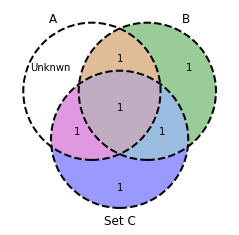

In [54]:

v = venn3(subsets=(1, 1, 1, 1, 1, 1, 1), set_labels = ('A', 'B', 'C'))
c = venn3_circles(subsets=(1, 1, 1, 1, 1, 1, 1), linestyle='dashed')
v.get_patch_by_id('100').set_alpha(1.0)
v.get_patch_by_id('100').set_color('white')
v.get_label_by_id('100').set_text('Unknwn')
v.get_label_by_id('C').set_text('Set C')

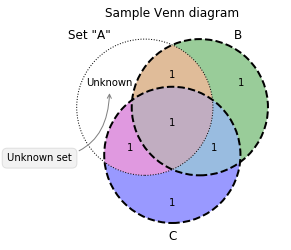

In [147]:

from matplotlib import pyplot as plt
import numpy as np
from matplotlib_venn import venn3, venn3_circles

plt.figure(figsize=(4,4))
v = venn3(subsets=(1, 1, 1, 1, 1, 1, 1), set_labels = ('A', 'B', 'C'))
v.get_patch_by_id('100').set_alpha(1.0)
v.get_patch_by_id('100').set_color('white')
v.get_label_by_id('100').set_position((-0.392934081494065, 0.24995460849196174))
v.get_label_by_id('100').set_text('Unknown')
v.get_label_by_id('A').set_text('Set "A"')
c = venn3_circles(subsets=(1, 1, 1, 1, 1, 1, 1), linestyle='dashed')
c[0].set_lw(1.0)
c[0].set_ls('dotted')
plt.title("Sample Venn diagram")
ann_text = plt.annotate('Unknown set', xy=v.get_label_by_id('100').get_position() - np.array([0, 0.05]), xytext=(-70,-70),
                        ha='center', textcoords='offset points', bbox=dict(boxstyle='round,pad=0.5', fc='gray', alpha=0.1),
                        arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.5',color='gray'))

In [142]:

v?

Type:        VennDiagram
String form: <matplotlib_venn._common.VennDiagram object at 0x000001E5A31D32E8>
File:        c:\programdata\anaconda3\lib\site-packages\matplotlib_venn\_common.py
Docstring:  
A container for a set of patches and patch labels and set labels, which make up the rendered venn diagram.
This object is returned by a venn2 or venn3 function call.


In [62]:

v.get_label_by_id?

Signature: v.get_label_by_id(id)
Docstring:
Returns a subset label by a "region id". 
A region id is a string '10', '01' or '11' for 2-circle diagram or a 
string like '001', '010', etc, for 3-circle diagram.
Alternatively, if the string 'A', 'B'  (or 'C' for 3-circle diagram) is given, the label of the
corresponding set is returned (or None).
File:      c:\programdata\anaconda3\lib\site-packages\matplotlib_venn\_common.py
Type:      method


In [119]:

tuples_list = sorted(values_dict.items(), key=lambda kv: len(kv[1]), reverse=True)
def show_values_venn(triples_list):
    subset_list = [set(t[1]) for t in triples_list]
    labels_list = tuple('\n'.join(t[0].split(' ')) for t in triples_list)
    venn_diagram = venn3(subsets=subset_list, set_labels=labels_list)
    circle_list = venn3_circles(subsets=subset_list)
    title_text = plt.title('Sacred Values Venn diagram')
    
    return circle_list, venn_diagram

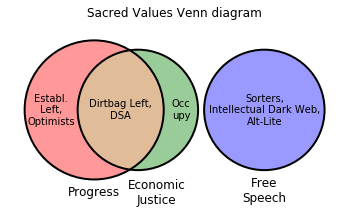

In [140]:

triples_list = tuples_list[:3]
circle_list, venn_diagram = show_values_venn(triples_list)
venn_diagram.get_label_by_id('100').set_text('Establ.\nLeft,\nOptimists')
venn_diagram.get_label_by_id('010').set_text('Occ\nupy')
venn_diagram.get_label_by_id('110').set_text('Dirtbag Left,\nDSA')
venn_diagram.get_label_by_id('001').set_text('Sorters,\nIntellectual Dark Web,\nAlt-Lite')
venn_diagram.get_label_by_id('B').set_position((-0.00968294436421356, -0.3951804571871522))

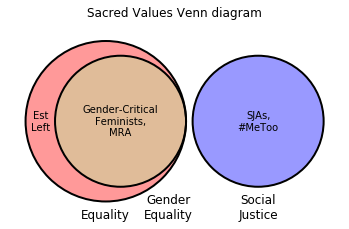

In [141]:

triples_list = tuples_list[3:6]
circle_list, venn_diagram = show_values_venn(triples_list)
venn_diagram.get_label_by_id('100').set_text('Est\nLeft')
venn_diagram.get_label_by_id('110').set_text('Gender-Critical\nFeminists,\nMRA')
venn_diagram.get_label_by_id('001').set_text('SJAs,\n#MeToo')
venn_diagram.get_label_by_id('B').set_position((0.07968294436421356, -0.3951804571871522))

In [132]:

b_circle_label = venn_diagram.get_label_by_id('B')
b_circle_label.set_position?

Signature: b_circle_label.set_position(xy)
Docstring:
Set the (*x*, *y*) position of the text.

Parameters
----------
xy : (float, float)
File:      c:\programdata\anaconda3\lib\site-packages\matplotlib\text.py
Type:      method


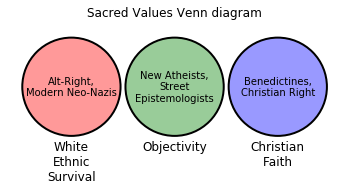

In [118]:

triples_list = tuples_list[6:9]
circle_list, venn_diagram = show_values_venn(triples_list)
venn_diagram.get_label_by_id('100').set_text('Alt-Right,\nModern Neo-Nazis')
venn_diagram.get_label_by_id('010').set_text('New Atheists,\nStreet\nEpistemologists')
venn_diagram.get_label_by_id('001').set_text('Benedictines,\nChristian Right')

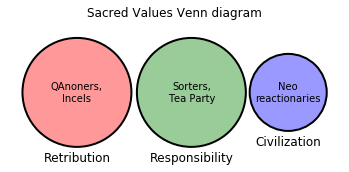

In [150]:

triples_list = tuples_list[9:12]
circle_list, venn_diagram = show_values_venn(triples_list)
venn_diagram.get_label_by_id('100').set_text('QAnoners,\nIncels')
venn_diagram.get_label_by_id('010').set_text('Sorters,\nTea Party')
venn_diagram.get_label_by_id('001').set_text('Neo\nreactionaries')

In [103]:

triples_list

[('White Ethnic Survival', ['Alt-Right', 'Modern Neo-Nazis']),
 ('Objectivity', ['New Atheists', 'Street Epistemologists']),
 ('Christian Faith', ['Benedictines', 'Christian Right'])]

In [91]:

tuples_list

[('Progress',
  ['Dirtbag Left',
   'DSA (Democratic Socialists of America)',
   'Establishment Left',
   'Optimists']),
 ('Economic Justice',
  ['Occupy', 'Dirtbag Left', 'DSA (Democratic Socialists of America)']),
 ('Free Speech', ['Sorters', 'Intellectual Dark Web', 'Alt-Lite']),
 ('Equality',
  ['Gender-Critical Feminists',
   'Establishment Left',
   'MRA (Mens Right Advocates)']),
 ('Gender Equality',
  ['Gender-Critical Feminists', 'MRA (Mens Right Advocates)']),
 ('Social Justice', ['SJAs (Social Justice Activists)', '#MeToo']),
 ('White Ethnic Survival', ['Alt-Right', 'Modern Neo-Nazis']),
 ('Objectivity', ['New Atheists', 'Street Epistemologists']),
 ('Christian Faith', ['Benedictines', 'Christian Right']),
 ('Retribution', ['QAnoners', 'Incels']),
 ('Responsibility', ['Sorters', 'Tea Party']),
 ('Civilization', ['Neoreactionaries']),
 ('Class Consciousness', ['Modern Neo-Marxists']),
 ('Sexual Retribution', ['Incels']),
 ('Intellectual Humility', ['Intellectual Dark Web']),


In [24]:

tribes_df

,TELOS,SACRED VALUES,MASTER STATUS,EXISTENTIAL THREATS,COMBATANTS,CAMPFIRE,CHIEFTAINS,MENTAL MODELS,FOREBEARS
MEMETIC TRIBE,,,,,,,,,
SJAs (Social Justice Activists),End social oppression,Social Justice,Social Activist,Kyriarchy,"Alt-Lite, Alt-Right, Sorters, Trumpists","Campuses, Tumblr, Twitter","Brianna Wu, Laurie Penny, Arthur Chu","Essentialism, Normativity, Intersectionality","Judith Butler, Kimberle Crenshaw, New Left"
Black Lives Matter,Justice for racialized people,Restorative Justice,African American,Systemic racism,"Alt-Lite, Alt-Right, Trumpists, Establishment ...","Protests, Campuses, Twitter","Alicia Garza, DeRay Mckesson, Ta Nehisi Coates","Black Bodies, Reparations, Cultural Appropriat...","Audre Lorde, Franz Fanon, Malcolm X"
#MeToo,End sexual harassment,"Empowerment, Social Justice",Empowered Woman / Ally,Weinstein level abuse,"Alt-Lite, MRA, Manosphere, Incels","Hollywood, MSM, Pop Culture","Tarana Burke, Oprah Winfrey, Alyssa Milano","Toxic Masculinity, Rape Culture, Pay Gap",Second and Third Wave Feminists
Gender-Critical Feminists,End patriarchy,Gender Equality,Liberated (biological) woman,Continued Patriarchy,"SJA, MRA","Speaking Tours, Twitter","Meghan Murphy, Germaine Greer, Sheilay Jeffreys","Rapid-Onset Gender Dysphoria, Womyn-born Womyn",Janice Raymond
Modern Neo-Marxists,Destruction of false consciousness,Class Consciousness,Revolutionary,Recuperation,"Establishment Left, Establishment Right","Student groups, Zero Books, Libcom","Douglas Lain, Mark Fisher, Slavoj Zizek","Hauntology, Capitalist Realism, Spectre of Ide...","Marxism, Situationist International, Frankfurt..."
Antifa,End fascism,Freedom (from fascism),Militant,Fascism,"Alt-Right, Alt-Lite, Neo-Nazis, Trumpists","Protests, It's Going Down, Crimethinc","Mark Bray, Natasha Lennard, Scott Crow","Direct Action, Diversity of Tactics, No Platfo...","Anti-Racist Action, Antifaschistische Aktion"
Occupy,Remove the 1% from power,Economic Justice,Protester,Police crackdown,"Establishment Left, Establishment Right","Protests, Student groups, zines","Kalle Lasn, Naomi Klein, David Graeber","The 99%, Culture Jamming, Crony Capitalism","Adbusters, Arab Spring"
Dirtbag Left,Overtake and revitalize the left,"Economic Justice, Progress",Unapologetic Socialist,Maintenance of pragamtic and centrist liberial...,"SJA, Alt-Right, Establishment Left","Weird Twitter, Chapo Trap House","Will Menaker, Matt Christman, Felix Biederman","The Ratio, Milkshake Duck, Tankie",Bernie Bros
DSA (Democratic Socialists of America),A democratically elected socialist state,"Economic Justice, Progress",Democratic Socialist,Neoliberalism,"Establishment Left, Establishment Right, Trump...","Twitter, Jacobin, Local chapters","Alexandria Oscasio-Cortez, Julia Salazar, Bern...","Social dividend, Calculation in kind, Cooperative","Michael Harrington, Jeremy Corbyn, Bernie Bros"


In [9]:
%%javascript
var kernel = IPython.notebook.kernel;
var body = document.body,  
    attribs = body.attributes;
var command = "notebook_path = " + "'"+attribs['data-notebook-path'].value+"'";
kernel.execute(command);

<IPython.core.display.Javascript object>

In [11]:
# %load ../../load_magic/nbviewer.py

from IPython.display import HTML

notebook_viewer_url = 'https://nbviewer.jupyter.org/github/dbabbitt/notebooks/blob/master/'
notebook_viewer_url += '/'.join(notebook_path.split('/')[1:])
html_str = '''Click
    <a href="{}" target="_blank">here</a>
to view notebook in nbviewer.'''.format(notebook_viewer_url)
HTML(html_str)